In [1]:
import os

from bs4 import BeautifulSoup
import pandas as pd
from tqdm.auto import tqdm

In [2]:
os.chdir("../../")
print(os.getcwd())

SAVE_FOLDER = "data/output/position_data"
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)

/Users/return0/Study/Learning/EPFL/ADA-group/ada-2024-project-theadacuates


In [3]:
HTML_FILE_PATH_PREFIX = 'data/raw/wpcd/wp'
HTML_NAVIGATION_FILE_PATH = '../../wp'

df_all_articles = pd.read_csv('data/output/processed_data/paths_processed.csv')

/var/folders/l1/2dblh1xj1vn_8mts7mgch1n00000gn/T/ipykernel_66502/289118005.py:4: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all_articles = pd.read_csv('data/output/processed_data/paths_processed.csv')


In [4]:
df_all_articles.head(3)

,hashed_ip,timestamp,duration,path,rating,path_list,source_link,target_link,finished,type_unfinished,n_click,n_back,date,click_rate,normalized_duration,freq_back,path_list_id,resolved_path_list_id,resolved_path_list_name
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,"['14th century', '15th century', '16th century...",14th century,African slave trade,True,NaN,9,0,2011-02-15 04:26:49,0.054217,18.444444,0.0,"[10, 12, 15, 3134, 377, 105, 128, 379, 143]","[10, 12, 15, 3134, 377, 105, 128, 379, 143]","['14th century', '15th century', '16th century..."
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,"['14th century', 'Europe', 'Africa', 'Atlantic...",14th century,African slave trade,True,NaN,5,0,2012-08-12 08:36:52,0.056818,17.600000,0.0,"[10, 1433, 128, 379, 143]","[10, 1433, 128, 379, 143]","['14th century', 'Europe', 'Africa', 'Atlantic..."
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,"['14th century', 'Niger', 'Nigeria', 'British ...",14th century,African slave trade,True,NaN,8,0,2012-10-03 23:10:40,0.057971,17.250000,0.0,"[10, 2982, 2984, 694, 3755, 128, 379, 143]","[10, 2982, 2984, 694, 3755, 128, 379, 143]","['14th century', 'Niger', 'Nigeria', 'British ..."


In [ ]:
df_all_articles['path'] = df_all_articles['path'].str.split(';')

In [ ]:
import re
import numpy as np

def get_html_file_path_by_name(name: str):
    return f'{HTML_FILE_PATH_PREFIX}/{name[0].lower()}/{name}.htm'

def get_html_href_by_name(name: str):
    href = f'{HTML_NAVIGATION_FILE_PATH}/{name[0].lower()}/{name}.htm'
    # match urllib encoding, e.g. %27 -> %2527
    if re.search(r'%\d*', href):
        href = href.replace('%', '%25')
    return href

def get_html_file(name: str):
    with open(get_html_file_path_by_name(name), 'r') as f:
        return f.read()

def get_target_link_position_by_pair(source_name: str, target_name: str = None):
    # get the position of the target link in all navigation links
    try:
        soup = BeautifulSoup(get_html_file(source_name),'html.parser')
        all_navigations = soup.find_all('a', href=True, class_=False)
        target_link = soup.find('a', href=get_html_href_by_name(target_name))
        # there could be more than one target links
        return len(all_navigations), [i for i, a in enumerate(all_navigations) if a==target_link]
    except Exception as e:
        print(f'ERROR: {source_name} and {target_name}')
        print(get_html_href_by_name(target_name))
        raise(e)

def get_target_link_position_by_list(path_list: list):
    # get the position of the target link in path
    if len(path_list) == 1:
        # duplicated code to accelerate the process
        soup = BeautifulSoup(get_html_file(path_list[0]),'html.parser')
        all_navigations = soup.find_all('a', href=True, class_=False)
        return [len(all_navigations)], [-1]

    number_of_navigation_links = []
    all_positions = []
    histories = [] # store the history of the path

    backclicks = False
    for i in range(len(path_list) - 1):
        source_name = path_list[i]
        target_name = path_list[i+1]

        # backclick
        if target_name == '<':
            if backclicks:
                histories.pop()
            backclicks = True
            continue
        backclicks = False
        if source_name == '<':
            source_name = histories[-1]
        else:
            histories.append(source_name)

        number_of_navigations, positions = get_target_link_position_by_pair(source_name, target_name)
        number_of_navigation_links.append(number_of_navigations)
        all_positions.append(positions)

    return number_of_navigation_links, all_positions

In [ ]:
from collections import defaultdict

# headings: h1, h2, h3
# tables: table, NavFrame
# paragraphs: p
# list: dl, ul, ol
# infobox: thumbcaption
# footer: footer
target_parents = ['h1', 'h2', 'h3', 'table', 'dl', 'ul', 'ol', 'p']
all_target_parents = target_parents + ['thumbcaption', 'nav', 'footer', 'undefined']

def filter_target_link_parent_by_element(element):
    for p in element.parents:
        if p.name in target_parents:
            return p.name
    if element.find_parent('div', class_='thumbcaption'):
        # thumb area
        return 'thumbcaption'
    if element.find_parent('div', class_='NavFrame'):
        # nav frame
        return 'nav'
    if element.find_parent('div', id='footer'):
        # thumb area
        return 'footer'
    return "undefined"

def get_target_link_parent_by_pair(source_name: str, target_name: str):
    soup = BeautifulSoup(get_html_file(source_name),'html.parser')
    all_navigations = soup.find_all('a', href=True, class_=False)
    result_nav_parents = defaultdict(int)
    for a in all_navigations:
        result_nav_parents[filter_target_link_parent_by_element(a)] += 1

    target_links = soup.find_all('a', href=get_html_href_by_name(target_name))

    result_target_parents = defaultdict(int)
    for a in target_links:
        result_target_parents[filter_target_link_parent_by_element(a)] += 1
    return dict(result_nav_parents), dict(result_target_parents)

def get_target_link_parent_by_list(path_list: list):
    # get the position of the target link in path
    all_nav_parents = []
    all_target_parents = []
    histories = [] # store the history of the path

    if len(path_list) > 1:
        backclicks = False
        for i in range(len(path_list) - 1):
            source_name = path_list[i]
            target_name = path_list[i+1]

            # backclick
            if target_name == '<':
                if backclicks:
                    histories.pop()
                backclicks = True
                continue
            backclicks = False
            if source_name == '<':
                source_name = histories[-1]
            else:
                histories.append(source_name)

            nav_parents, target_parents = get_target_link_parent_by_pair(source_name, target_name)
            all_nav_parents.append(nav_parents)
            all_target_parents.append(target_parents)

    return all_nav_parents, all_target_parents

In [ ]:
col_target_parents = []
col_nav_parents = []
for path in tqdm(df_all_articles['path']):
    try:
        all_nav_parents, all_target_parents = get_target_link_parent_by_list(path)
        col_nav_parents.append(all_nav_parents)
        col_target_parents.append(all_target_parents)
    except Exception as e:
        print(path)
        raise(e)

  0%|          | 0/74140 [00:00<?, ?it/s]

In [ ]:
number_of_navigation_links_paths = []
positions_paths = []
for path in tqdm(df_all_articles['path']):
    try:
        number_of_navigation_links, positions = get_target_link_position_by_list(path)
        number_of_navigation_links_paths.append(number_of_navigation_links)
        positions_paths.append(positions)
    except Exception as e:
        print(path)
        raise(e)

  0%|          | 0/74140 [00:00<?, ?it/s]

In [ ]:
# df_sample = df_all_articles.head(10000)
df_result = df_all_articles
df_result['all_nav_parents'] = col_nav_parents
df_result['target_parents'] = col_target_parents
df_result['num_nav_links'] = number_of_navigation_links_paths
df_result['path_positions'] = positions_paths

# df_result.to_csv('data/output/base_data/all_articles_processed_path_parents.csv', index=False)

In [ ]:
reserve_cols = ['path', 'source_link', 'target_link', 'finished', 'type_unfinished','all_nav_parents', 'target_parents', 'num_nav_links', 'path_positions']
df_result[reserve_cols].to_csv(f'{SAVE_FOLDER}/path_links_distribution.csv', index=False)

## Plots

In [5]:
import ast
import pandas as pd

df_position = pd.read_csv(f'{SAVE_FOLDER}/path_links_distribution.csv')
df_position['all_nav_parents'].fillna("[]", inplace=True)
df_position['target_parents'].fillna("[]", inplace=True)
df_position['num_nav_links'] = df_position['num_nav_links'].apply(ast.literal_eval)
df_position['path_positions'] = df_position['path_positions'].apply(ast.literal_eval)
df_position['all_nav_parents'] = df_position['all_nav_parents'].apply(ast.literal_eval)
df_position['target_parents'] = df_position['target_parents'].apply(ast.literal_eval)

/var/folders/l1/2dblh1xj1vn_8mts7mgch1n00000gn/T/ipykernel_66502/832843580.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_position['all_nav_parents'].fillna("[]", inplace=True)
/var/folders/l1/2dblh1xj1vn_8mts7mgch1n00000gn/T/ipykernel_66502/832843580.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

In [6]:
from collections import defaultdict, Counter

# count the number of all navigation links' parent
count_all_nav_parents_group = defaultdict(int)

for parents in df_position['all_nav_parents']:
    for nav_parents in parents:
        for k, v in nav_parents.items():
            count_all_nav_parents_group[k] += v

# count the number of the target links' parent
count_target_parents_group = defaultdict(int)
for parents in df_position['target_parents']:
    for nav_parents in parents:
        for k, v in nav_parents.items():
            count_target_parents_group[k] += v

In [7]:
def group_categories(parents_dict: dict):
    # group structural categories
    return {
        'heading': parents_dict.get('h1', 0) + parents_dict.get('h2', 0) + parents_dict.get('h3', 0),
        'paragraph': parents_dict.get('p', 0),
        'table': parents_dict.get('table', 0) + parents_dict.get('NavFrame', 0),
        'list': parents_dict.get('ul', 0) + parents_dict.get('ol', 0) + parents_dict.get('dl', 0),
        'infobox': parents_dict.get('thumbcaption', 0),
        'footer': parents_dict.get('footer', 0),
        'undefined': parents_dict.get('undefined', 0)
    }

target_parents_group_categories = group_categories(count_target_parents_group)
all_nav_parents_group_categories = group_categories(count_all_nav_parents_group)
# Normalize by the number of all navigation links
normalized_target_parents_group_categories = {k: v / all_nav_parents_group_categories[k] for k, v in target_parents_group_categories.items()}

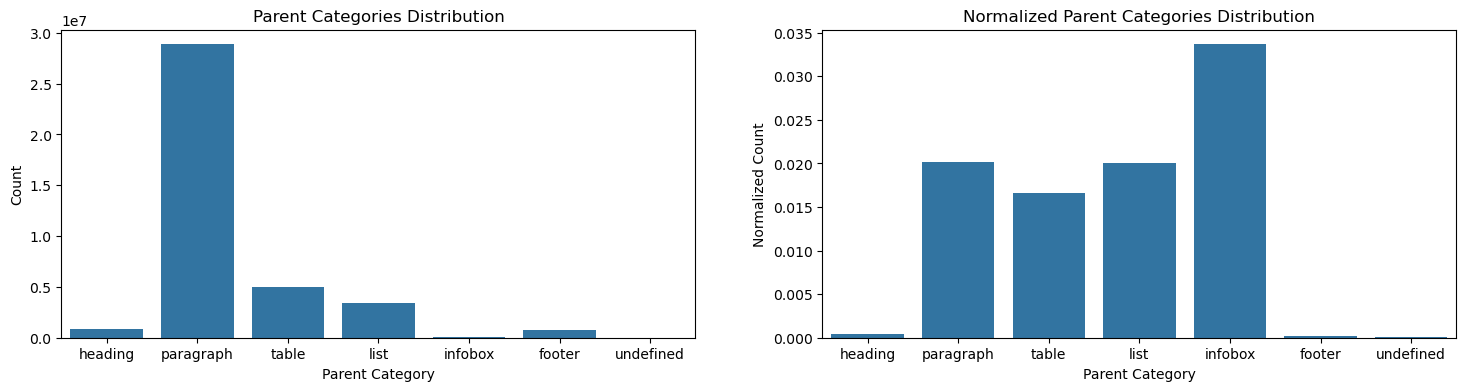

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.barplot(ax=ax[0], x=list(all_nav_parents_group_categories.keys()), y=list(all_nav_parents_group_categories.values()))
ax[0].set_title('Parent Categories Distribution')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Parent Category')


sns.barplot(ax=ax[1], x=list(normalized_target_parents_group_categories.keys()), y=list(normalized_target_parents_group_categories.values()))
ax[1].set_title('Normalized Parent Categories Distribution')
ax[1].set_ylabel('Normalized Count')
ax[1].set_xlabel('Parent Category')

plt.show()

In [9]:
# flatten the number of navigation links
num_nav_links_group = [num for navs in df_position['num_nav_links'] for num in navs]
# flatten the number of positions
positions_group = []

for positions in df_position['path_positions']:
    for position in positions:
        if isinstance(position, list):
            positions_group.extend(position)
        else:
            positions_group.append(position)
# # count the frequency
sr_num_nav_links = pd.Series(Counter(num_nav_links_group).values(), index=Counter(num_nav_links_group).keys())
sr_positions_group = pd.Series(Counter(positions_group).values(), index=Counter(positions_group).keys())

# remove the position -1
sr_positions_group.drop(index=-1, inplace=True)

In [10]:
# create cumulative sum of each navigation links position
sr_cum_nav_links = []
for i in range(1, max(sr_num_nav_links.index)+1):
    sr_cum_nav_links.append(sr_num_nav_links[sr_num_nav_links.index >= i].sum())

sr_cum_nav_links = pd.Series(sr_cum_nav_links, index=range(1, max(sr_num_nav_links.index)+1))

In [11]:
sr_cum_nav_links.sort_index(inplace=True)
sr_positions_group.sort_index(inplace=True)

In [12]:
from scipy import stats
sr_cum_nav_links_filtered = sr_cum_nav_links.loc[sr_positions_group.index]
sr_cum_nav_links_filtered.sort_index(inplace=True)
sr_positions_group.sort_index(inplace=True)

# Normalize by the maximum value, range from 0 to 1
sr_cum_nav_links_filtered /= max(sr_cum_nav_links_filtered)
sr_positions_group /= max(sr_positions_group)

print('Null Hypothesis: The distributions of cumulative number of navigation links and positions are the same.')
print('Alternative Hypothesis: The distributions of cumulative number of navigation links and positions are not the same.')
statistic, pvalue = stats.ks_2samp(sr_cum_nav_links_filtered, sr_positions_group)

if pvalue < 0.05:
    print('P-value is less than 0.05. Thus, we reject the null hypothesis. The distributions are significantly different.')
else:
    print('P-value is greater than 0.05. Thus, we fail to reject the null hypothesis. The distributions are not significantly different.')

Null Hypothesis: The distributions of cumulative number of navigation links and positions are the same.
Alternative Hypothesis: The distributions of cumulative number of navigation links and positions are not the same.
P-value is less than 0.05. Thus, we reject the null hypothesis. The distributions are significantly different.


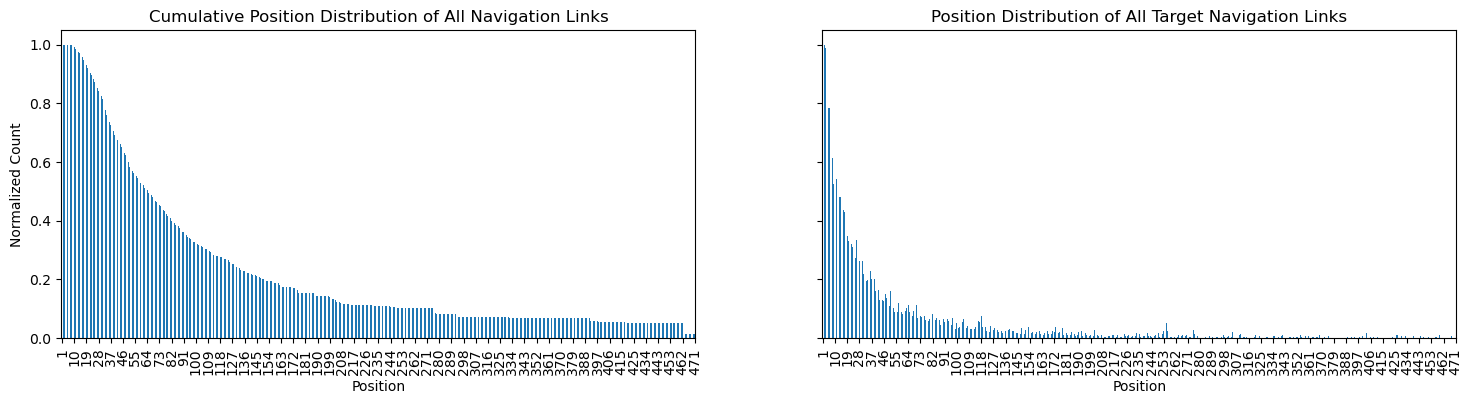

In [13]:
num_xticks = 50

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(18, 4))

sr_cum_nav_links_filtered.plot(kind='bar', ax=ax[0])
ax[0].set_title('Cumulative Position Distribution of All Navigation Links')
ax[0].set_ylabel('Normalized Count')
ax[0].set_xlabel('Position')
ax[0].set_xticks(ax[0].get_xticks()[::len(ax[0].get_xticks())//num_xticks])

sr_positions_group.plot(kind='bar', ax=ax[1])
ax[1].set_title('Position Distribution of All Target Navigation Links')
ax[1].set_ylabel('Normalized Count')
ax[1].set_xlabel('Position')
ax[1].set_xticks(ax[1].get_xticks()[::len(ax[1].get_xticks())//num_xticks]) 

plt.show()

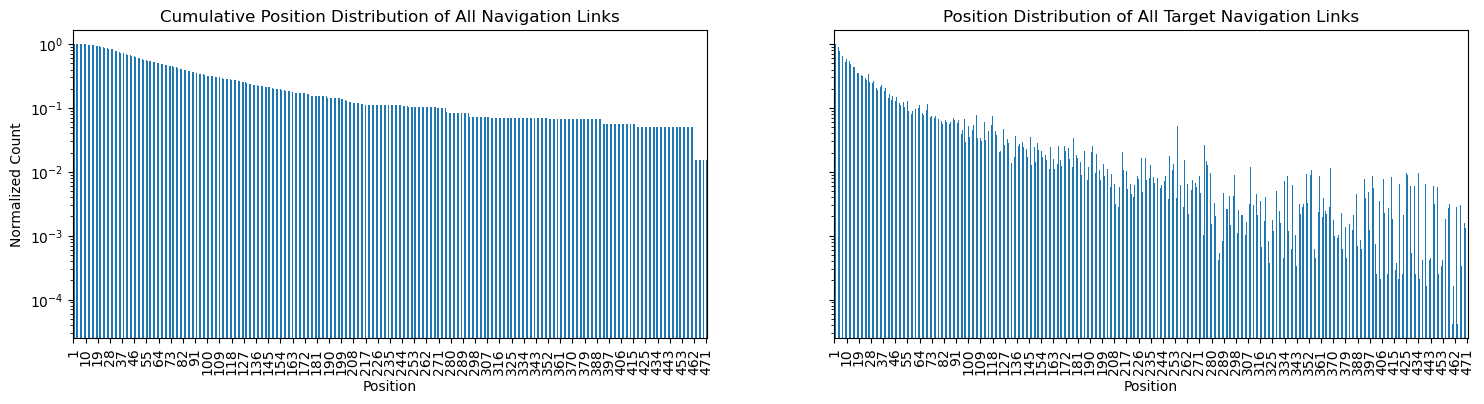

In [14]:
# log yscale
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(18, 4))

sr_cum_nav_links_filtered.plot(kind='bar', ax=ax[0], logy=True)
ax[0].set_title('Cumulative Position Distribution of All Navigation Links')
ax[0].set_ylabel('Normalized Count')
ax[0].set_xlabel('Position')
ax[0].set_xticks(ax[0].get_xticks()[::len(ax[0].get_xticks())//num_xticks])

sr_positions_group.plot(kind='bar', ax=ax[1], logy=True)
ax[1].set_title('Position Distribution of All Target Navigation Links')
ax[1].set_ylabel('Normalized Count')
ax[1].set_xlabel('Position')
ax[1].set_xticks(ax[1].get_xticks()[::len(ax[1].get_xticks())//num_xticks]) 

plt.show()

# Analysis

## Structural elements catch human Attnetion

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

<span style="color: blue;">**Pepito:**</span>

Perhaps the distribution of target links within an article could also influence people's choice of the next target. Although the actual display may differ due to players' varying screen sizes, the structure they see is the same. I can still approach this from a structural perspective.


![structure-elements](https://p.ipic.vip/ugyvgo.png)

In [16]:
# Load data
SAVE_FOLDER = "data/output/position_data"
df_position = pd.read_csv(f'{SAVE_FOLDER}/path_links_distribution.csv')
df_position['all_nav_parents'].fillna("[]", inplace=True)
df_position['target_parents'].fillna("[]", inplace=True)
df_position['num_nav_links'] = df_position['num_nav_links'].apply(ast.literal_eval)
df_position['path_positions'] = df_position['path_positions'].apply(ast.literal_eval)
df_position['all_nav_parents'] = df_position['all_nav_parents'].apply(ast.literal_eval)
df_position['target_parents'] = df_position['target_parents'].apply(ast.literal_eval)

/var/folders/l1/2dblh1xj1vn_8mts7mgch1n00000gn/T/ipykernel_66502/3876842278.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_position['all_nav_parents'].fillna("[]", inplace=True)
/var/folders/l1/2dblh1xj1vn_8mts7mgch1n00000gn/T/ipykernel_66502/3876842278.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

In [17]:
from src.utils.position import get_parents_distribution
# Category distribution
df_target_parents_group_categories, df_all_nav_parents_group_categories = get_parents_distribution(df_position)
df_normalized_target_parents_group_categories = df_target_parents_group_categories / df_all_nav_parents_group_categories

In [18]:
percentage_undefined_all = df_all_nav_parents_group_categories.loc['undefined'] / df_all_nav_parents_group_categories.sum() * 100
percentage_undefined_target = df_target_parents_group_categories.loc['undefined'] / df_target_parents_group_categories.sum() * 100

print(f'The link positions can be categorized into heading, paragraph, table, list, infobox, and footer. Links that do not fall into these categories account for only {round(percentage_undefined_all.values[0], 5)} % of all links and {round(percentage_undefined_target.values[0], 5)} % of target links.')

The link positions can be categorized into heading, paragraph, table, list, infobox, and footer. Links that do not fall into these categories account for only 0.04996 % of all links and 0.00014 % of target links.


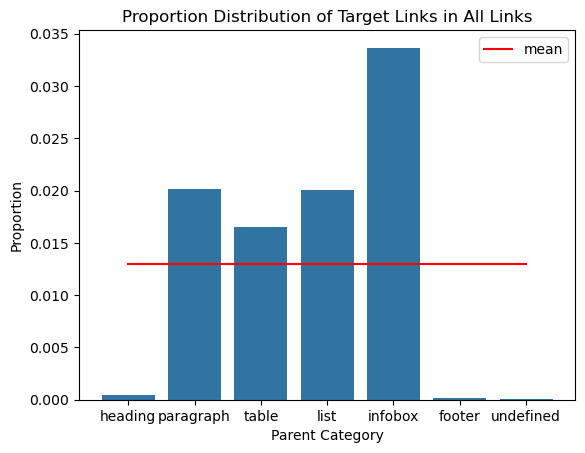

In [19]:
plt.figure()

sns.barplot(x=df_normalized_target_parents_group_categories.index, y=df_normalized_target_parents_group_categories['count'].values)
sns.lineplot(x=df_normalized_target_parents_group_categories.index, y=df_normalized_target_parents_group_categories['count'].mean(), color='red', label='mean')
# ax[1].axhline(y=0, linewidth=2, color='red', )
plt.title('Proportion Distribution of Target Links in All Links')
plt.ylabel('Proportion')
plt.xlabel('Parent Category')

plt.show()

Wow! It’s definitely different. Players click on the infobox the most, followed by the paragraph, table, and list, with very few clicks on the heading and footer.

In [20]:
df_position_finished = df_position[df_position['finished']]
df_position_unfinished = df_position[~df_position['finished']]

# Category distribution
df_target_parents_group_categories_finished, df_all_nav_parents_group_categories_finished = get_parents_distribution(df_position_finished)
df_normalized_target_parents_group_categories_finished = df_target_parents_group_categories_finished / df_all_nav_parents_group_categories_finished

# Add type
df_target_parents_group_categories_finished['type'] = 'finished'
df_all_nav_parents_group_categories_finished['type'] = 'finished'
df_normalized_target_parents_group_categories_finished['type'] = 'finished'

# Category distribution
df_target_parents_group_categories_unfinished, df_all_nav_parents_group_categories_unfinished = get_parents_distribution(df_position_unfinished)
df_normalized_target_parents_group_categories_unfinished = df_target_parents_group_categories_unfinished / df_all_nav_parents_group_categories_unfinished

# Add type
df_target_parents_group_categories_unfinished['type'] = 'unfinished'
df_all_nav_parents_group_categories_unfinished['type'] = 'unfinished'
df_normalized_target_parents_group_categories_unfinished['type'] = 'unfinished'

# Merge
df_merged_target_parents = pd.concat([df_target_parents_group_categories_finished, df_target_parents_group_categories_unfinished])
df_merged_all_nav_parents = pd.concat([df_all_nav_parents_group_categories_finished, df_all_nav_parents_group_categories_unfinished])
df_merged_normalized_target_parents = pd.concat([df_normalized_target_parents_group_categories_finished, df_normalized_target_parents_group_categories_unfinished])


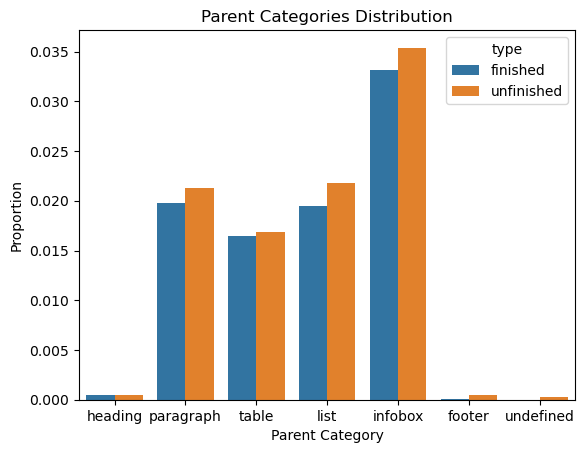

In [21]:
plt.figure()


sns.barplot(data=df_merged_normalized_target_parents,  x=df_merged_normalized_target_parents.index, y='count', hue='type')
plt.title('Parent Categories Distribution')
plt.ylabel('Proportion')
plt.xlabel('Parent Category')

plt.show()

In that case, I can compare the distribution of target links for successful completions with that of incomplete targets to see if there are any differences.

In [22]:
# remove "undefined"
indices = ['heading','paragraph','table','list','infobox','footer']


print("Null Hypothesis: People's choices regarding the structure where target links are located have no impact on whether they can successfully complete the game.")
print("Alternative Hypothesis: People's choice of the structure containing the target link can influence their success in completing the game.")
statistic, p_value = ks_2samp(df_normalized_target_parents_group_categories_finished.loc[indices]['count'].values, df_normalized_target_parents_group_categories_unfinished.loc[indices]['count'].values)

if p_value < 0.05:
    print("P-value is less than 0.05. Thus, we reject the null hypothesis. People's choice of the structure containing the target link can influence their success in completing the game.")
else:
    print("P-value is greater than 0.05. Thus, we fail to reject the null hypothesis. People's choices regarding the structure where target links are located have no impact on whether they can successfully complete the game.")

Null Hypothesis: People's choices regarding the structure where target links are located have no impact on whether they can successfully complete the game.
Alternative Hypothesis: People's choice of the structure containing the target link can influence their success in completing the game.
P-value is greater than 0.05. Thus, we fail to reject the null hypothesis. People's choices regarding the structure where target links are located have no impact on whether they can successfully complete the game.


Oh no, although people show a preference in their choices, it does not affect whether they can successfully complete the game.

## Link Position & Human Laziness

<span style="color: blue;">**Pepito:**</span>

Since the structure can have an impact, does the order in which the links appear also have an effect?

In [23]:
from src.utils.position import get_position_distribution

# Compute the position distribution
sr_num_nav_links, df_positions_group, df_cum_nav_links = get_position_distribution(df_position)
df_positions_group = df_positions_group[df_positions_group['position'] != -1]

df_cum_nav_links.sort_values('position', inplace=True)
df_positions_group.sort_values('position', inplace=True)

sr_cum_nav_links_filtered = df_cum_nav_links[df_cum_nav_links['position'].isin(df_positions_group['position'])]['count']
sr_cum_nav_links_filtered.sort_index(inplace=True)
df_positions_group.sort_index(inplace=True)

# Normalize by the maximum value, range from 0 to 1
sr_cum_nav_links_filtered /= max(sr_cum_nav_links_filtered)
df_positions_group['count'] /= df_positions_group['count'].max()

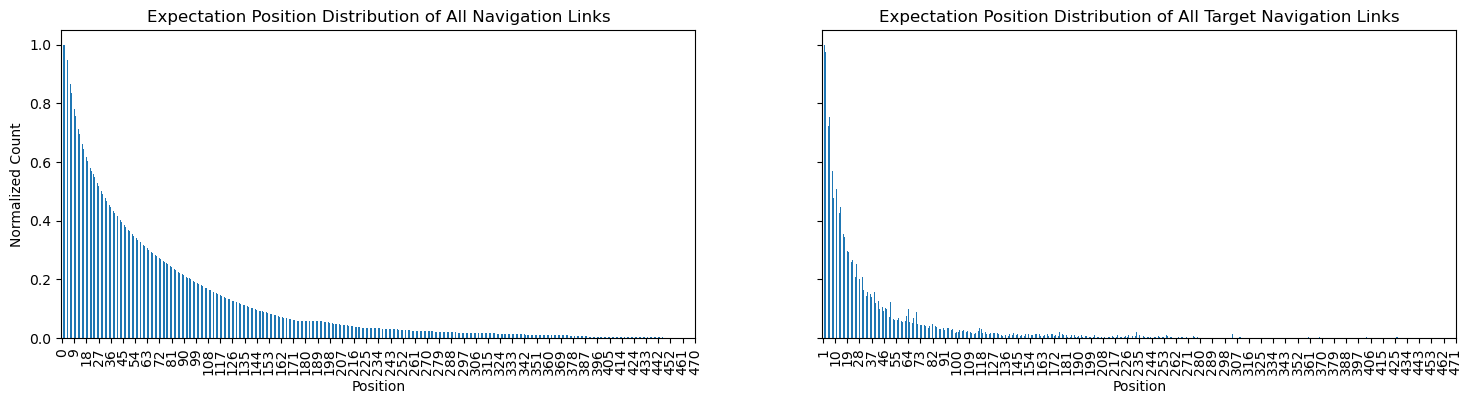

In [24]:
num_xticks = 50

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(18, 4))

sr_cum_nav_links_filtered.plot(kind='bar', ax=ax[0])
ax[0].set_title('Expectation Position Distribution of All Navigation Links')
ax[0].set_ylabel('Normalized Count')
ax[0].set_xlabel('Position')
ax[0].set_xticks(ax[0].get_xticks()[::len(ax[0].get_xticks())//num_xticks])

df_positions_group.plot(x='position', y='count', kind='bar', ax=ax[1], legend=False)
ax[1].set_title('Expectation Position Distribution of All Target Navigation Links')
ax[1].set_ylabel('Normalized Count')
ax[1].set_xlabel('Position')
ax[1].set_xticks(ax[1].get_xticks()[::len(ax[1].get_xticks())//num_xticks]) 

plt.show()

In [25]:
print('Null Hypothesis: The distributions of cumulative number of navigation links and positions are the same.')
print('Alternative Hypothesis: The distributions of cumulative number of navigation links and positions are not the same.')
statistic, pvalue = ks_2samp(sr_cum_nav_links_filtered, df_positions_group['count'])

print('The p-value is: ', pvalue)

if pvalue < 0.05:
    print('P-value is less than 0.05. Thus, we reject the null hypothesis. The distributions are significantly different.')
else:
    print('P-value is greater than 0.05. Thus, we fail to reject the null hypothesis. The distributions are not significantly different.')


Null Hypothesis: The distributions of cumulative number of navigation links and positions are the same.
Alternative Hypothesis: The distributions of cumulative number of navigation links and positions are not the same.
The p-value is:  1.8479752495215878e-37
P-value is less than 0.05. Thus, we reject the null hypothesis. The distributions are significantly different.


Great! Clearly, players tend to click on links that appear earlier.

In [26]:
# Compute the position distribution - finished
_, df_positions_group_finished, df_cum_nav_links_finished = get_position_distribution(df_position_finished)
df_positions_group_finished = df_positions_group_finished[df_positions_group_finished['position'] != -1]

df_cum_nav_links_finished.sort_values('position', inplace=True)
df_positions_group_finished.sort_values('position', inplace=True)

df_positions_group_finished.sort_index(inplace=True)

# Normalize by the maximum value, range from 0 to 1
df_positions_group_finished['count'] /= df_positions_group_finished['count'].max()

# Compute the position distribution - unfinished
_, df_positions_group_unfinished, df_cum_nav_links_unfinished = get_position_distribution(df_position_unfinished)
df_positions_group_unfinished = df_positions_group_unfinished[df_positions_group_unfinished['position'] != -1]

df_cum_nav_links_unfinished.sort_values('position', inplace=True)
df_positions_group_unfinished.sort_values('position', inplace=True)


df_positions_group_unfinished.sort_index(inplace=True)

# Normalize by the maximum value, range from 0 to 1
df_positions_group_unfinished['count'] /= df_positions_group_unfinished['count'].max()

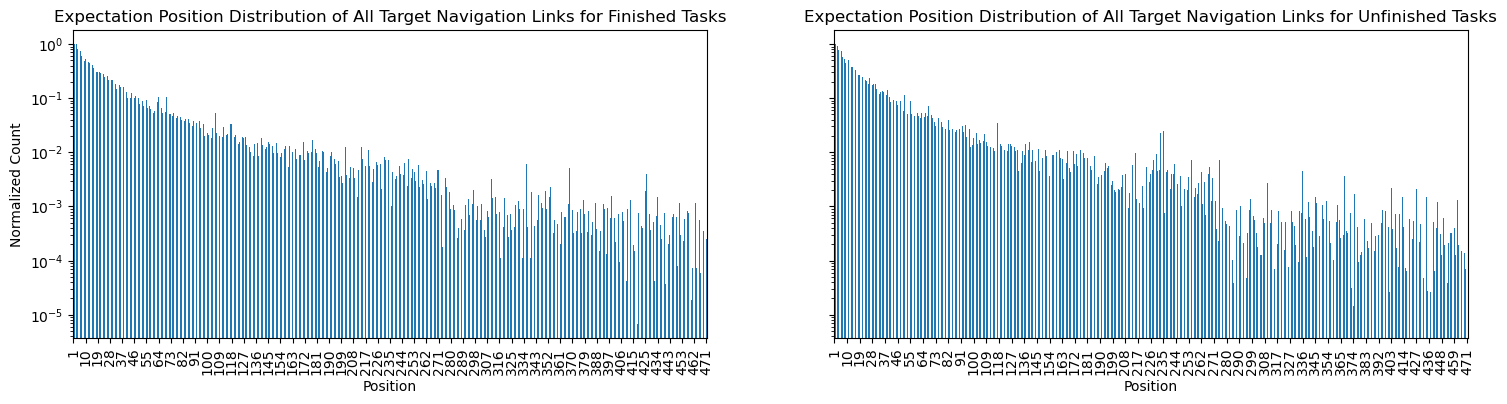

In [27]:
num_xticks = 50

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(18, 4))

df_positions_group_finished.plot(x='position', y='count', kind='bar', ax=ax[0], legend=False, logy=True)
ax[0].set_title('Expectation Position Distribution of All Target Navigation Links for Finished Tasks')
ax[0].set_ylabel('Normalized Count')
ax[0].set_xlabel('Position')
ax[0].set_xticks(ax[0].get_xticks()[::len(ax[0].get_xticks())//num_xticks])

df_positions_group_unfinished.plot(x='position', y='count', kind='bar', ax=ax[1], legend=False, logy=True)
ax[1].set_title('Expectation Position Distribution of All Target Navigation Links for Unfinished Tasks')
ax[1].set_ylabel('Normalized Count')
ax[1].set_xlabel('Position')
ax[1].set_xticks(ax[1].get_xticks()[::len(ax[1].get_xticks())//num_xticks]) 

plt.show()

In [28]:
print('Null Hypothesis: Players who successfully completed the game and those who did not show the same preference in the order of link selection.')
print('Alternative Hypothesis: Players who successfully completed the game and those who did not show different preferences in the order of link selection.')
statistic, pvalue = ks_2samp(df_positions_group_finished['count'], df_positions_group_unfinished['count'])

print('The p-value is: ', pvalue)

if pvalue < 0.05:
    print('P-value is less than 0.05. Thus, we reject the null hypothesis. Players who successfully completed the game and those who did not show different preferences in the order of link selection.')
else:
    print('P-value is greater than 0.05. Thus, we fail to reject the null hypothesis. Players who successfully completed the game and those who did not show the same preference in the order of link selection.')


Null Hypothesis: Players who successfully completed the game and those who did not show the same preference in the order of link selection.
Alternative Hypothesis: Players who successfully completed the game and those who did not show different preferences in the order of link selection.
The p-value is:  0.025509189128175347
P-value is less than 0.05. Thus, we reject the null hypothesis. Players who successfully completed the game and those who did not show different preferences in the order of link selection.


Although the significance is not high, people's choice to select links earlier does have an impact.